### Config

In [2]:
import csv
import requests
import json
import re
import urllib.request
import os
import re
from bs4 import BeautifulSoup
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from threading import Thread
from nltk.corpus import stopwords
dutch_stopwords = stopwords.words("dutch")
complete_case_url = 'https://uitspraken.rechtspraak.nl/inziendocument?id='


In [3]:
!python --version
!jupyter --version

Python 3.8.5
jupyter core     : 4.6.3
jupyter-notebook : 6.1.4
qtconsole        : 4.7.7
ipython          : 7.19.0
ipykernel        : 5.3.4
jupyter client   : 6.1.7
jupyter lab      : 3.2.6
nbconvert        : 6.0.7
ipywidgets       : 7.5.1
nbformat         : 5.0.8
traitlets        : 5.0.5


In [4]:
query = 'drugs'
base_verdicts_url = 'https://uitspraken.rechtspraak.nl/api/zoek' 
complete_case_url = 'https://uitspraken.rechtspraak.nl/inziendocument?id='
case_count = 10000000 ## Amount of cases to retrieve. If you want max, just do an insanely high number, it stops when it fetched all cases. Backend does not accept values like 'max'.
save_text_location = os.getcwd() + '/court case data/testdata/' # You have to have created this folder first. 
cases_df = pd.DataFrame()

index = ["id", "verdict_date", "publication_date", "verdict_type", "jurisdiction_type"]


files = {
        "StartRow": 0,
        "PageSize": case_count,
        "ShouldReturnHighlights":'true',
        "ShouldCountFacets":'true',
        "SortOrder":"Relevance",
        "SearchTerms":[{"Term":query,"Field":"AlleVelden"}],
        "Contentsoorten":[],
        "Rechtsgebieden":[],
        "Instanties":[],
        "DatumPublicatie":[],
        "DatumUitspraak":[],
        "Advanced":{"PublicatieStatus":"AlleenGepubliceerd"},
        "CorrelationId":"9abc658b0ce64f8786992af6965aabc4",
        "Proceduresoorten":[]
    }

# Court Case Scraper

### Config

In [ ]:
query = 'drugs'
base_verdicts_url = 'https://uitspraken.rechtspraak.nl/api/zoek' 
complete_case_url = 'https://uitspraken.rechtspraak.nl/inziendocument?id='
case_count = 10000000 ## Amount of cases to retrieve. If you want max, just do an insanely high number, it stops when it fetched all cases. Backend does not accept values like 'max'.
save_text_location = os.getcwd() + '/court case data/testdata/' # You have to have created this folder first. 
cases_df = pd.DataFrame()

index = ["id", "verdict_date", "publication_date", "verdict_type", "jurisdiction_type"]


files = {
        "StartRow": 0,
        "PageSize": case_count,
        "ShouldReturnHighlights":'true',
        "ShouldCountFacets":'true',
        "SortOrder":"Relevance",
        "SearchTerms":[{"Term":query,"Field":"AlleVelden"}],
        "Contentsoorten":[],
        "Rechtsgebieden":[],
        "Instanties":[],
        "DatumPublicatie":[],
        "DatumUitspraak":[],
        "Advanced":{"PublicatieStatus":"AlleenGepubliceerd"},
        "CorrelationId":"9abc658b0ce64f8786992af6965aabc4",
        "Proceduresoorten":[]
    }


### Old Methods

Method to extract the text from the casefiles. Search the uitsprakenBaseURL with case ID to get the html file. 
Filter through the html file with BeautifulSoup and look for either class 'uitspraak' or 'conclusie' as the standard seems to switch between cases. 
Parse html file to textfile to get a clean text file. Replace \n and commas with empty strings.

In [ ]:
def getCaseText(caseId):
    response = requests.get(uitsprakenBaseUrl + caseId)
    soup = BeautifulSoup(response.text, 'html.parser')
    soup_content = soup.find("div", {"id": 'content'})
    uitspraak_html = soup_content.find('div', {'class': 'uitspraak'})
    if soup_content.find('div', {'class': 'uitspraak'}) is not None:
        uitspraak_html = soup_content.find('div', {'class': 'uitspraak'})
    elif soup_content.find('div', {'class': 'conclusie'}) is not None:
        uitspraak_html =  soup_content.find('div', {'class': 'conclusie'})
    uitspraak = uitspraak_html.get_text()
    uitspraak = uitspraak.replace(',', '')
    return uitspraak

Method to parse each case individually. Save case attributes to cases.csv and save each case text to a .txt file in /data/ folder and name it the case ID.

In [ ]:
def parseCaseInfo(results):
    global cases_df
    for case in results:
        caseText = getCaseText(case['TitelEmphasis'])
        parsedId = case['TitelEmphasis'].replace(':', '-') # Case id's apparentlyl use ':'. We cannot save files with ':' in the name, so we replace them with '-'.
        f= open(save_text_location + parsedId + ".txt","w+", encoding='utf-8') # Doesn't work without encoding. 
        f.write(caseText)
        case['Case ID'] = parsedId
        cases_df = cases_df.append(case, ignore_index = True)
        print('Processed case', case['Case ID'])
    cases_df.to_csv('cases3.csv', index=False)

Method to retrieve raw data from the backend. Backend url is at the top in the Config. files = complete request payload the backend expects to receive. 


In [ ]:
def queryUitspraak():
    print("Querying")
    files = {
        "StartRow": 0,
        "PageSize": case_count,
        "ShouldReturnHighlights":'true',
        "ShouldCountFacets":'true',
        "SortOrder":"Relevance",
        "SearchTerms":[{"Term":searchQuery,"Field":"AlleVelden"}],
        "Contentsoorten":[],
        "Rechtsgebieden":[],
        "Instanties":[],
        "DatumPublicatie":[],
        "DatumUitspraak":[],
        "Advanced":{"PublicatieStatus":"AlleenGepubliceerd"},
        "CorrelationId":"9abc658b0ce64f8786992af6965aabc4",
        "Proceduresoorten":[]
    }
    try:
        response = requests.post(baseUrl, json=files)
        responseJSON = json.loads(response.text)
        results = responseJSON['Results']
        print(len(results), "records!")
        parseCaseInfo(results)
    except urllib.error.HTTPError as err:
        print(err) 

queryUitspraak()

### Methods

Get cases from https://uitspraken.rechtspraak.nl/api/zoek.
Returns a collection of dictionaries.

In [ ]:
def get_cases(config):
    try:
        response = requests.post(base_verdicts_url, json=config)
        responseJSON = json.loads(response.text)
        results = responseJSON['Results']
        print(len(results), "records found.")
        return results
    except urllib.error.HTTPError as err:
        print(err)   

Create a dataframe of all queried cases with the following columns: 
- Id
- Verdict date
- Publication date
- Verdict type
- Jurisdiction type

In [ ]:
def create_cases_df(cases):
    cases_df = pd.DataFrame(columns = index)
    cases_df = pd.DataFrame(columns = index)
    for case in cases:
        curr_case = pd.Series([case["TitelEmphasis"].replace(":", "-"), case["Uitspraakdatum"], case["Publicatiedatum"], case["UitspraakdatumType"], case["Rechtsgebieden"]], index = index)
        cases_df = cases_df.append(curr_case, ignore_index=True)
    cases_df.to_csv('./court case data/testdata.csv', index=False)
    return cases_df
            

Save the text of all cases from the dataframe to a .txt file located in /data folder. 

In [ ]:
def save_case_text(df):
#     case_count = len(df)
    i = 1
    for case in df["id"]:
        try:
            response = requests.get(complete_case_url + case.replace("-", ":"))
            soup = BeautifulSoup(response.text, 'html.parser')
            soup_content = soup.find("div", {"id": 'content'})
            uitspraak_html = soup_content.find('div', {'class': 'uitspraak'})
            if soup_content.find('div', {'class': 'uitspraak'}) is not None:
                uitspraak_html = soup_content.find('div', {'class': 'uitspraak'})
            elif soup_content.find('div', {'class': 'conclusie'}) is not None:
                uitspraak_html =  soup_content.find('div', {'class': 'conclusie'})
            uitspraak = uitspraak_html.get_text()
            uitspraak = uitspraak.replace(',', '')
            parsed_id = case.replace(":", "-")
            f= open(save_text_location + parsed_id + ".txt","w+", encoding='utf-8') # Doesn't work without encoding. 
            f.write(uitspraak)
#             print(f"{i}/{case_count} {parsed_id}")
#             clear_output(wait=True)
#             i += 1
        except Exception as e:
            print(f"Error in saving. {e}")
    print("Finished")
            

### Create dataset

In [ ]:
cases = get_cases(files)
cases_df = create_cases_df(cases)
# save_case_text(cases_df)


In [ ]:
def clean_string(dirty):
    
    clean_str = dirty.strip()
    clean_str = clean_str.lower()
    
    return clean_str

In [ ]:
def save_case_text(df):
    for i in range(len(df)):
#         case_id = df.iloc[i]['id'].replace('-', ':')
        case_id = 'ECLI:NL:RBZWB:2020:2646'
        print(f"\n CASE: {case_id} \n")
        try:
            response = requests.get(complete_case_url + case_id)
            soup = BeautifulSoup(response.text, 'html.parser')
            soup_content = soup.find("div", {"id": 'content'})
            if df.iloc[i]['verdict_type'] == 'uitspraak':
                statement_content = soup_content.find('div', {'class': 'uitspraak'})
            elif df.iloc[i]['verdict_type'] == 'conclusie':
                statement_content = soup_content.find('div', {'class': 'conclusie'})
            
            sections = {}
            for el in statement_content.find_all(attrs={'class': 'section'}):
                section_title = clean_string(el.find('h2').text)
                print(section_title)
                sections[section_title] = el
                
#             print(sections.keys())
#             print(sections['8 De beslissing'].text)
            
            
           
        except Exception as e:
            print(f"Error in saving: {e}")

            
save_case_text(cases_df[:1])

In [ ]:
%%time
save_case_text(cases_df[:1])

In [ ]:
%%time
cases_df_1 = cases_df[:5000]
cases_df_2 = cases_df[5000:10000]
cases_df_3 = cases_df[10000:15000]
cases_df_4 = cases_df[15000:]

print(len(cases_df_1))
print(len(cases_df_2))

t1 = Thread(target=save_case_text ,args=(cases_df_1,))
t2 = Thread(target=save_case_text ,args=(cases_df_2,))
t3 = Thread(target=save_case_text ,args=(cases_df_3,))
t4 = Thread(target=save_case_text ,args=(cases_df_4,))


t1.start()
t2.start()
t3.start()
t4.start()

t1.join()
t2.join()
t3.join()
t4.join()

print("finished")

# Create / Filter dataset

### Update Dataset

Create updated csv with all relevant cases

In [ ]:
cases = get_cases(files)
cases_df = create_cases_df(cases)


In [ ]:
print(cases_df)

In [ ]:
dataPath = os.getcwd() + '/court case data/testdata/'

list_of_cases = cases_df['id'].tolist()
list_of_created_cases = [case.replace('.txt', '') for case in os.listdir(dataPath)]
list_to_create = [case for case in list_of_cases if case not in list_of_created_cases]
if len(list_to_create) > 0:
    print(f"Creating {len(list_to_create)} new cases.")
    df_to_save = cases_df[cases_df['id'].isin(list_to_create)]
    save_case_text(df_to_save)
    print("Done")

### Create and clean full dataframe

Create:

In [5]:
dataPath = os.getcwd() + '/court case data/testdata/'
caseCount = len(os.listdir(dataPath))
data = []
try:
    os.remove(dataPath + ".DS_Store")
except:
    print("No file DS_Store")
for filename in os.listdir(dataPath):
    f = open(os.path.join(dataPath, filename), encoding='utf-8')
    data.append([filename.replace('.txt', ''), f.read()])

verdict_df = pd.DataFrame(data, columns=["id", "case text"])
cases_df = pd.read_csv('./court case data/testdata.csv')
merged_df = cases_df.join(verdict_df.set_index('id'), on='id', how='left')

merged_df["verdict_date"] = pd.to_datetime(merged_df["verdict_date"])
merged_df["publication_date"] = pd.to_datetime(merged_df["publication_date"])


No file DS_Store


<ipython-input-5-79d4849703e4>:16: UserWarning: Parsing '23-06-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  merged_df["verdict_date"] = pd.to_datetime(merged_df["verdict_date"])
<ipython-input-5-79d4849703e4>:16: UserWarning: Parsing '13-04-2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  merged_df["verdict_date"] = pd.to_datetime(merged_df["verdict_date"])
<ipython-input-5-79d4849703e4>:16: UserWarning: Parsing '28-05-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  merged_df["verdict_date"] = pd.to_datetime(merged_df["verdict_date"])
<ipython-input-5-79d4849703e4>:16: UserWarning: Parsing '21-07-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  merged_df["verdict_date"] = pd.to_datetime(merged_df["verdict_date"])
<ipython-input-5-79d4849703e4>:16: UserW

<ipython-input-5-79d4849703e4>:17: UserWarning: Parsing '24-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  merged_df["publication_date"] = pd.to_datetime(merged_df["publication_date"])
<ipython-input-5-79d4849703e4>:17: UserWarning: Parsing '17-09-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  merged_df["publication_date"] = pd.to_datetime(merged_df["publication_date"])
<ipython-input-5-79d4849703e4>:17: UserWarning: Parsing '30-08-2012' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  merged_df["publication_date"] = pd.to_datetime(merged_df["publication_date"])
<ipython-input-5-79d4849703e4>:17: UserWarning: Parsing '29-04-2008' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  merged_df["publication_date"] = pd.to_datetime(merged_df["publication_date"])
<ipython

In [5]:
print(merged_df.columns)

Index(['id', 'verdict_date', 'publication_date', 'verdict_type',
       'jurisdiction_type', 'case text'],
      dtype='object')


Clean:

In [ ]:
total_len_uncleaned = 0
for i in range(len(merged_df)):
    currtext = merged_df.iloc[i]["case text"]
    try:
        length = len(currtext.split())
    except:
        print('Please update the dataset')
    total_len_uncleaned += length
print(f"Total words in uncleaned dataset: {total_len_uncleaned}")

In [ ]:
cleaned_df = merged_df.copy()
cleaned_df['case text'] = cleaned_df['case text'].apply(lambda x: ' '.join([word for word in x.split() if word not in dutch_stopwords]))
print("Done")

In [ ]:
total_len_cleaned = 0
for i in range(len(cleaned_df)):
    currtext = cleaned_df.iloc[i]["case text"]
    length = len(currtext.split())
    total_len_cleaned += length

print(f"Original count: {total_len_uncleaned} \n Cleaned count: {total_len_cleaned} \n Difference: {total_len_uncleaned - total_len_cleaned}")
print(f"{round((total_len_uncleaned - total_len_cleaned) / total_len_uncleaned * 100, 2)}% decrease")


### Creating some plots and metrics

In [ ]:
jurisdiction_types_dict = {
    "Strafrecht": 0,
    "Civiel recht": 0,
    "Verbintenissenrecht": 0,
    "Bestuursrecht": 0,
    "Belastingrecht": 0,
    "Materieel strafrecht": 0,
    "Civiel recht": 0,
    "Personen- en familierecht": 0,
    "Ambtenarenrecht": 0,
    "Socialezekerheidsrecht": 0,
    "Insolventierecht": 0,
    "Penitentiair strafrecht": 0,
    "Bestuursprocesrecht": 0,
    "Arbeidsrecht": 0,
    "Burgerlijk procesrecht": 0,
    "Europees strafrecht": 0,
    "Omgevingsrecht": 0,
    "Internationaal strafrecht": 0,
    "Internationaal publiekrecht": 0,
    "Strafprocesrecht": 0
}

# print(cleaned_df.jurisdiction_type.unique())
for i in range(len(cleaned_df)):
    curr = cleaned_df.iloc[i]
    for j in jurisdiction_types_dict.keys():
        if j in curr['jurisdiction_type']:
            jurisdiction_types_dict[j] = jurisdiction_types_dict[j] + 1

plt.bar(range(len(jurisdiction_types_dict)), list(jurisdiction_types_dict.values()), align='center')
plt.xticks(range(len(jurisdiction_types_dict)), list(jurisdiction_types_dict.keys()))
plt.xticks(rotation=90)

In [ ]:
verdict_types = cleaned_df.verdict_type.unique()
verdict_types_counts = [cleaned_df['verdict_type'].value_counts()[0], cleaned_df['verdict_type'].value_counts()[1]]

plt.bar(verdict_types, verdict_types_counts)
plt.title('Verdict type counts')


In [ ]:
plt.rcParams["figure.figsize"] = (20,5)

cleaned_df_date_plot = cleaned_df["verdict_date"].value_counts().resample("1M").sum()
plt.plot(cleaned_df_date_plot)

In [ ]:
print(cleaned_df["verdict_date"].value_counts())

### Filter for trafficking keywords

In [ ]:
print(f"Original case count: {len(cleaned_df)}")

trafficking_df = pd.DataFrame()
# trafficking_words = ["smokkel", "transport", "invoer", "import", "export", " uitvoer "]
trafficking_words = ["smokkel", "transport", "invoer", "import", "export"]

# trafficking_words = ["smokkel", "transport"]


for i in range(len(cleaned_df)):
    curr = cleaned_df.iloc[i]
    if any(x in curr["case text"] for x in trafficking_words):
        trafficking_df = trafficking_df.append(curr)
    
print(f"Filtered for trafficking:  {len(trafficking_df)} articles.")

In [ ]:
def get_links(df):
    link_list = []
    for i in range(len(df)):
        curr = df.iloc[i]
        link = complete_case_url + curr['id'].replace('-', ':')
        link_list.append(link)
    print(link_list)

In [ ]:
get_links(trafficking_df)

In [ ]:
print(trafficking_df[-20:])

In [ ]:
countries_df = pd.read_csv('dutch-countries.csv', encoding = "ISO-8859-1")
countries_list = list(countries_df["Countries"])
# countries_list.remove('Nederland')

In [ ]:
countries = []
for i in range(len(trafficking_df)):
    curr_text = trafficking_df.iloc[i]['case text']
    curr_countries = []
    for j in countries_list:
        if j in curr_text:
            curr_countries.append(j)
    countries.append(curr_countries)
    
trafficking_df['countries'] = countries

In [ ]:
print(trafficking_df[-20:]['countries'])

In [ ]:
from collections import Counter

resample = "1Y"
index = cleaned_df["verdict_date"].value_counts().resample(resample).sum().index

complete_country_count_df = pd.DataFrame(index=index)
for i in countries_list:
    country_mention_date = []
    for j in range(len(trafficking_df)):
        curr = trafficking_df.iloc[j]
        if i in curr['countries']:
            country_mention_date.append(curr['verdict_date'])
    if len(country_mention_date) > 20:
        counted = Counter(country_mention_date)
        sorted_dict = dict(sorted(counted.items(), key=lambda item: item[0]))
        dates = list(sorted_dict.keys())
        values = list(sorted_dict.values())
        country_df = pd.DataFrame(values, index=dates).resample(resample).sum()
        complete_country_count_df[i] = country_df
        plt.plot(country_df, label=i)
        
plt.legend()
plt.show()

        
    
    

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)

complete_country_count_df = complete_country_count_df.fillna(0)
plt.plot(complete_country_count_df[20:])
plt.legend(complete_country_count_df.columns.tolist())
plt.show()

### TF-IDF / K means

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
import numpy as np

documents = trafficking_df["case text"]
total_stop_words = stopwords.words('dutch') + stopwords.words('english')
# vectorizer = TfidfVectorizer(max_df=0.20, min_df=10, stop_words=total_stop_words , use_idf=True,  lowercase=True)
vectorizer = TfidfVectorizer(min_df=10, stop_words=total_stop_words , use_idf=True,  lowercase=True)


X = vectorizer.fit_transform(documents)
X = X.astype('float32')

Create elbow curve to determine best k value

In [ ]:
distortions = []
K = range(1,20)
for k in K:
    print(k)
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
true_k = 8
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200)

labels = model.fit_predict(X)
trafficking_df["K means cluster"] = labels

X_array = X.toarray()
pca = PCA(n_components=2).fit(X_array)
XPCA = pca.transform(X_array)

u_labels = np.unique(labels)
for i in u_labels:
    plt.scatter(XPCA[labels == i , 0] , XPCA[labels == i , 1] , label = i)
plt.legend()
plt.show()

In [ ]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
terms_df = pd.DataFrame()
for i in range(true_k):
    curr = []
    for ind in order_centroids[i, :19]:
        curr.append(terms[ind])
    terms_df[i] = curr

print(terms_df)

print(trafficking_df["K means cluster"].value_counts())

### 

### 

# NLP

### BERTje

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification, AutoModel
import torch


#### Fill Mask

In [ ]:
pipe = pipeline('fill-mask', model='GroNLP/bert-base-dutch-cased')

In [ ]:
for res in pipe('Mijn naam is [MASK].'):
    print(res['sequence'])

#### NER

In [ ]:
nlp = pipeline('ner', model='wietsedv/bert-base-dutch-cased-finetuned-conll2002-ner')


In [ ]:
example = "Mijn naam is Cas en mijn moeder heet Susanne en samen wonen wij in Griekenland"
example = "- voornoemde (hoeveelheid) cocaïne aan boord van voornoemd luchtvaartuig (op Curaçao) verstopt in en/of gebracht naar en/of getracht te verstoppen in een of meer zogenaamde vuilnistrolley('s) en/of cateringtrolley('s) in het cateringgedeelte van voornoemd luchtvaartuig. "
ner_results = nlp(example)
ner_results

In [ ]:
trafficking_df.iloc[4]

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base")
model = AutoModel.from_pretrained("pdelobelle/robbert-v2-dutch-base")

In [ ]:
nlp = pipeline('ner', model=model, tokenizer=tokenizer)

In [ ]:
example = "hallo mijn naam is cas"

ner_results = nlp(example)
ner_results

### robBert

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [ ]:
pipe = pipeline('fill-mask', model='pdelobelle/robbert-v2-dutch-base')

In [ ]:
for res in pipe('Hallo, ik ben RobBERT, een <mask> taalmodel van de KU Leuven.'):
    print(res['sequence'])

In [ ]:
ner = pipeline('ner', model='pdelobelle/robbert-v2-dutch-ner')

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-ner")

model = AutoModelForTokenClassification.from_pretrained("pdelobelle/robbert-v2-dutch-ner")
ner = pipeline(model=model, tokenizer=tokenizer)

In [ ]:
ner("Hallo mijn naam is Cas.")

### SpaCy

In [ ]:
!python -m spacy download nl_core_news_md

In [ ]:
import spacy
from spacy.lang.nl.examples import sentences 

nlp = spacy.load("nl_core_news_md")
doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)

In [ ]:
nlp = spacy.load('nl_core_news_md')

In [ ]:
def show_ents(doc): 
    if doc.ents: 
        for ent in doc.ents: 
#             print(ent.label_)
            if ent.label_ == "GPE":
                
                print(ent.text+' - '+ent.label_+ ' - '+str(spacy.explain(ent.label_))) 
    else: print('No named entities found.')
        
def check_place(chunk):
    if doc.ents:
        has_GPE = False
        for ent in doc.ents:
            if ent.label_ == "GPE":
                has_GPE = True
    return has_GPE

In [ ]:
doc = nlp(case_text_1)
show_ents(doc)


# SpaCy Dependency & NER analysis

In [ ]:
from spacy import displacy


In [ ]:
selected_case = merged_df[merged_df['id'] == "ECLI-NL-GHARN-2004-AO7555"].iloc[0]

In [ ]:
case_text = selected_case['case text']

In [47]:
example_text = "Op 9 december 2013 is door douanemedewerkers 300 kg cocaïne in de haven van Rotterdam onderschept. De container waarin de cocaïne zat, was afkomstig uit Costa Rica en moest worden vervoerd naar de [adres] te Rotterdam om daar te worden gekeurd."




In [ ]:
import re
split_case_text = re.split('\n', example_text)

def check_place(chunk):
    has_GPE = False
    if doc.ents:
        for ent in doc.ents:
            if ent.label_ == "GPE":
                has_GPE = True
    return has_GPE

def show_GPE(doc): 
    if doc.ents: 
        for ent in doc.ents: 
#             print(ent.label_)
#             if ent.label_ == "GPE":
            print(ent.text+' - '+ent.label_+ ' - '+str(spacy.explain(ent.label_))) 
    else: print('No named entities found.')
        
        
filtered_case_text = []
for i in split_case_text:
    if i != '':
        doc = nlp(i)
        if check_place(doc):
            filtered_case_text.append(i)



In [ ]:

displacy.render(nlp(example_text), style="ent")

In [292]:
bb = '''Het hof heeft bij de straftoemeting in het bijzonder in aanmerking genomen -en vindt daarin de redenen die tot de keuze van een onvoorwaardelijke vrijheidsstraf van na te melden duur leiden- dat verdachte zich op grote schaal heeft schuldig gemaakt aan smokkel van cocaïne en XTC-pillen van Nederland naar Duitsland, Italië, de Verenigde Staten van Amerika, Canada en Zweden. De verdovende middelen waren kennelijk bestemd om verder te worden verspreid onder personen die aan bovengenoemde drugs verslaafd zijn. Door aldus te handelen heeft verdachte de volksgezondheid in gevaar gebracht.

Daarnaast heeft verdachte een vervalst paspoort in zijn bezit gehad, waardoor hij het maatschappelijk vertrouwen in de echtheid van reisdocumenten heeft geschaad.

Tevens neemt het hof bij de straftoemeting in aanmerking dat verdachte in het verleden bij herhaling is veroordeeld wegens het plegen van strafbare feiten.''' 

displacy.render(nlp(bb), style='ent')



In [293]:
for ent in nlp(bb).ents:
    if ent.label_ == "GPE":
        print(ent)


Nederland
Duitsland
Italië
Verenigde Staten van Amerika
Canada
Zweden


In [294]:
displacy.render(nlp(bb),style='dep')

In [295]:
type_1 = ["van", "uit", "vanuit"]
type_2 = ["naar"]

In [317]:

def extract_details(text):
    source = None
    destination = None
    drug_type = None
    for token in nlp(text):
        if token.ent_type_ == "GPE":
            # Check if related to an adposition:
            for child in token.children:
                if child.pos_ == "ADP":
                    if child.text in type_1:
                        source = token
                    elif child.text in type_2:
                        destination = token
                    else:
                        "Adposition not recognized"
    
    if destination is not None:
        for child in destination.children:
            if (child.pos_ == "NOUN" or child.pos_ == "PROPN") and child.dep_ == "conj":
                country = child.text
                for grandchild in child.children:
                    if grandchild.pos_ == "PROPN" and grandchild.dep_ == "flat":
                        country = f"{country} {grandchild.text}"
                destination = f"{destination}, {country}"

    if source is not None:
        for ancestor in source.ancestors:
            if ancestor.pos_ == "NOUN" and ancestor.dep_ == "nmod" and ancestor.ent_type_ == "DRUG":
                drug_type = ancestor.text
                for child in ancestor.children:
                    if child.pos_ == "NOUN" and child.dep_ == "conj":
                        drug_type = f"{drug_type}, {child}"


    return(f"Source: {source}\n Destination: {destination}\n Drug: {drug_type}")

In [318]:
print(extract_details(bb))

Source: None
 Destination: Duitsland, Italië
 Drug: None


In [ ]:
print(extract_details(case_text))

In [ ]:
for token in nlp(example_text):
    if token.ent_type_ == "GPE":
        # Check if related to an adposition:
        for child in token.children:
            if child.pos_ == "ADP":
                print(child, token)

In [ ]:
for token in nlp(bb):
    if token.head.pos_ == "VERB":
        print(token)

In [ ]:
displacy.serve(nlp(bb), style='dep')


In [311]:
bb = "Het hof heeft bij de straftoemeting in het bijzonder in aanmerking genomen -en vindt daarin de redenen die tot de keuze van een onvoorwaardelijke vrijheidsstraf van na te melden duur leiden- dat verdachte zich uit winstbejag aan smokkel van cocaïne naar Duitsland en Italië heeft schuldig gemaakt."
displacy.render(nlp(bb), style="ent")



In [312]:
displacy.render(nlp(bb), style="dep")

# Pipeline

## Split chunks by \n and keep chunk if contains drug

Create drugs list from txt

In [6]:
my_file = open("drugs list.txt", "r", encoding='utf-8')
my_file = my_file.readlines()
drugs_list = []
for i in my_file:
    drugs_list.append(i.replace('\n', ''))

my_file = open("countries list.txt", "r", encoding='utf-8')
my_file = my_file.readlines()
countries_list = []
for i in my_file:
    countries_list.append(i.replace('\n', ''))
        

Split case text into chunks with regular expression and keep it if it contains drug

In [7]:
def fix_countries(text):
    for country in countries_list:
        text = text.replace(country, country.replace(' ', ''))
    return text


In [8]:
def get_chunks(ecli):
    parsed_id = ecli.replace(':', '-')
    selected_case = merged_df[merged_df['id'] == parsed_id].iloc[0]
    case_text = selected_case['case text']
    split_case_text = re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])|\n', case_text)
    
    relevant_chunks = []
    for i in split_case_text:
        if any(drug in i for drug in drugs_list):
            corrected_chunk = fix_countries(i)
            relevant_chunks.append(corrected_chunk)
    return relevant_chunks

## Analyze individual chunks

In [9]:
def configure_spacy_model():
    # Create dict of drug pattern and quantity pattern
    pattern_list = []
    
    drugs_ent_list = []
    for i in drugs_list:
        pattern_list.append({"label": "DRUG", "pattern": [{"lower": i}]})
    
    quantity_rule = {"label": "QUANTITY", "pattern": [{"IS_DIGIT": True}, {"LOWER": "gram"}]}
    pattern_list.append(quantity_rule)
    
    for i in countries_list:
        pattern_list.append({"label": "GPE", "pattern": [{"lower": i.replace(' ', '').lower()}]})
    
    # Add drug and quantity rules to the model
    config = {
   "phrase_matcher_attr": None,
   "validate": True,
   "overwrite_ents": True,
   "ent_id_sep": "||",
    }
    ruler = nlp.add_pipe("entity_ruler", config=config)

    #List of Entities and Patterns
#     patterns = drugs_ent_list
    ruler.add_patterns(pattern_list)


In [10]:
def extract_chunk_info(txt):
    source_country = None
    total_info = []
    for token in nlp(txt):
        info = {}
        drug_info = {}
        countries = []
        
        if token.ent_type_ == "DRUG":
            info = {"drug": token.text}
            
            ## Get source and destination
            for ancestor in token.ancestors:
                for nephew in ancestor.children:
                    if nephew.ent_type_ == "GPE" or nephew.ent_type_ == "LOC":
                        countries.append(nephew)
                        for child in nephew.children:
                            if child.dep_ == "conj" and child.ent_type_ == "GPE" or child.ent_type_ == "LOC":
                                countries.append(child.text)
                            elif child.pos_ == "ADP" and child.dep_ == "case":
                                adj = child.text
            if len(countries) > 0 :
                try:
                    info[adj] = countries
                except:
                    info['land'] = countries
                        
            ## Get volume
            for ancestors in token.ancestors:
                for nephew in ancestors.children:
                    if nephew.ent_type_ == "QUANTITY" or nephew.ent_type_ == "CARDINAL":
                        for second_nephew in nephew.children:
                            if second_nephew.is_digit != nephew.is_digit:
                                if second_nephew.is_digit:
                                    info['volume'] = second_nephew.text
                                    info['volume_type'] = nephew.text
                                else:
                                    info['volume'] = nephew.text
                                    info['volume_type'] = second_nephew.text
            if 'volume' not in info:
                for child in token.children:
                    if (child.dep_ == "det" and child.like_num) or (child.dep_ == "nummod"):
                        info['volume'] = child.text
                                
        if len(info) > 1:
#             print(info)
            total_info.append(info)
    return total_info

In [11]:
relevant_chunks = get_chunks('ECLI:NL:OGEAC:2015:9')

In [ ]:
for i in relevant_chunks:
    print(i, '\n')
    print(extract_chunk_info(i), '\n')

In [20]:
relevant_chunks = get_chunks("ECLI:NL:GHARN:2004:AO7555")

In [16]:
to_prepositions = ['naar', 'via']
from_prepositions = ['bij', 'in', 'te', 'van', 'vanuit']

def parse_extracted_info(chunks):
    doc_info = {}
    for i in chunks:
        chunk_info = extract_chunk_info(i)
        for drug_info in chunk_info:
            curr_drug = drug_info['drug']
            if curr_drug not in doc_info:
                doc_info[curr_drug] = {}
            curr_dict = doc_info[curr_drug]
            for key in drug_info:
#                 if key in to_prepositions:
#                     curr_dict['to'] = drug_info[key]
#                 elif key in from_prepositions:
#                     curr_dict['from'] = drug_info[key]
#                 elif key != 'drug':
#                     curr_dict[key] = drug_info[key]
                if key in to_prepositions:
                    curr_dict['to'] = drug_info[key]
                elif key in from_prepositions:
                    curr_dict['from'] = drug_info[key]
                elif key != 'drug':
                    curr_dict[key] = drug_info[key]
               
                        
    return doc_info

        
parse_extracted_info(relevant_chunks)

{'cocaïne': {'volume': 'zoveel', 'volume_type': 'kilo', 'to': [SintMaarten]}}

## Run pipeline

Create drugs list from txt file

In [13]:
my_file = open("drugs list.txt", "r", encoding='utf-8')
my_file = my_file.readlines()
drugs_list = []
for i in my_file:
    drugs_list.append(i.replace('\n', ''))

my_file = open("countries list.txt", "r", encoding='utf-8')
my_file = my_file.readlines()
countries_list = []
for i in my_file:
    countries_list.append(i.replace('\n', ''))
        


In [14]:
import spacy
from spacy import displacy
# !python -m spacy download nl_core_news_md
nlp = spacy.load('nl_core_news_md')
configure_spacy_model()

In [36]:
def pipeline(ecli):
    chunks = get_chunks(ecli)
    info = parse_extracted_info(chunks)
    return info

# pipeline("ECLI:NL:GHARN:2004:AO7555")
pipeline("ECLI:NL:GHAMS:2011:BQ8090")

{'cocaïne': {'to': [Amsterdam],
  'volume': '3',
  'volume_type': 'kilogram',
  'from': [Brazilië]}}

In [ ]:
for i in range(len(merged_df[100:400])):
    ecli = merged_df.iloc[i]['id']
    print(ecli)
    print(pipeline(ecli))

In [37]:
for i in range(len(merged_df[:200])):
    ecli = merged_df.iloc[i]['id']
#     print(ecli)
    
#     print(pipeline(ecli))

    curr_dict = pipeline(ecli)
    for key in curr_dict:
        if 'to' in curr_dict[key] and 'from' in curr_dict[key]:
            print(f"{ecli}:\n {curr_dict}\n")
        

ECLI-NL-OGHACMB-2020-78:
 {'cocaïne': {'to': [Curaçao], 'from': [Curaçao]}, 'hennep': {'to': [Curaçao], 'from': [Curaçao]}}

ECLI-NL-OGHACMB-2020-78:
 {'cocaïne': {'to': [Curaçao], 'from': [Curaçao]}, 'hennep': {'to': [Curaçao], 'from': [Curaçao]}}

ECLI-NL-OGHACMB-2020-82:
 {'hennep': {'volume': '80', 'volume_type': 'kg', 'to': [Curacao], 'from': [Curaçao]}, 'cocaïne': {'to': [Curacao], 'from': [Curaçao]}}

ECLI-NL-OGHACMB-2020-82:
 {'hennep': {'volume': '80', 'volume_type': 'kg', 'to': [Curacao], 'from': [Curaçao]}, 'cocaïne': {'to': [Curacao], 'from': [Curaçao]}}

ECLI-NL-RBAMS-2017-9087:
 {'cocaïne': {'volume': '49', 'volume_type': 'kilo', 'from': [Rotterdam], 'to': [Colombia, Nederland]}, 'cocaïnetransport': {'volume': 'een'}}

ECLI-NL-RBAMS-2017-9085:
 {'cocaïne': {'volume': '49', 'volume_type': 'kilo', 'from': [Rotterdam], 'to': [Colombia, Nederland]}, 'cocaïnetransport': {'volume': 'een'}}

ECLI-NL-RBAMS-2017-9088:
 {'cocaïne': {'volume': '49', 'volume_type': 'kilo', 'from': [R

In [41]:
def render_entities(txt):
    doc = nlp(txt)
    displacy.render(doc, style="ent")
    
def get_entities(txt):
    doc = nlp(txt)
    for ent in doc.ents:
        print(ent, ent.label_)

In [50]:
temp_text = "De verdachte heeft 15 kilogram cocaine van Sint Maarten naar Nederland gesmokkeld"
temp_text = "Op 9 december 2013 is door douanemedewerkers 300 kg cocaïne in de haven van Rotterdam onderschept. De container waarin de cocaïne zat, was afkomstig uit Costa Rica en moest worden vervoerd naar de [adres] te Rotterdam om daar te worden gekeurd."


In [51]:
render_entities(temp_text)

In [52]:
displacy.render(nlp(temp_text), style="dep")

## Sandbox

In [60]:
extext = 'De verdachte heeft omstreeks 1 januari 2000 5 kilogram cocaïne van Nederland naar Duitsland vervoerd.'
extext2 = 'De verdachte heeft omstreeks 1 januari 2000 5 kilogram cocaïne in 6 kilo bananen van Nederland naar Duitsland en Italie vervoerd.'
extext3 = "- op of omstreeks 27 juli 2001 te Hengelo (O) althans in het arrondissement Almelo ongeveer 62.000 XTC-pillen althans een hoeveelheid van een materiaal bevattende MDA en/of MDMA en/of MDEA en/of "


In [54]:
render_entities(extext)

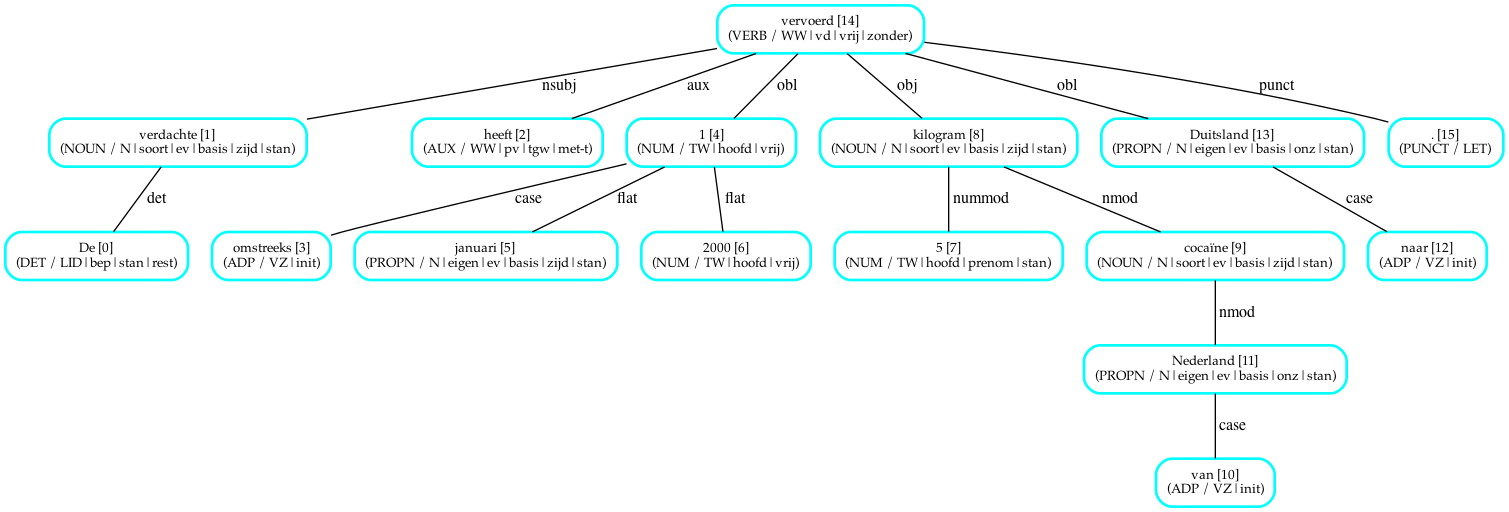

In [55]:
png = visualise_spacy_tree.create_png(nlp(extext))
display(Image(png))

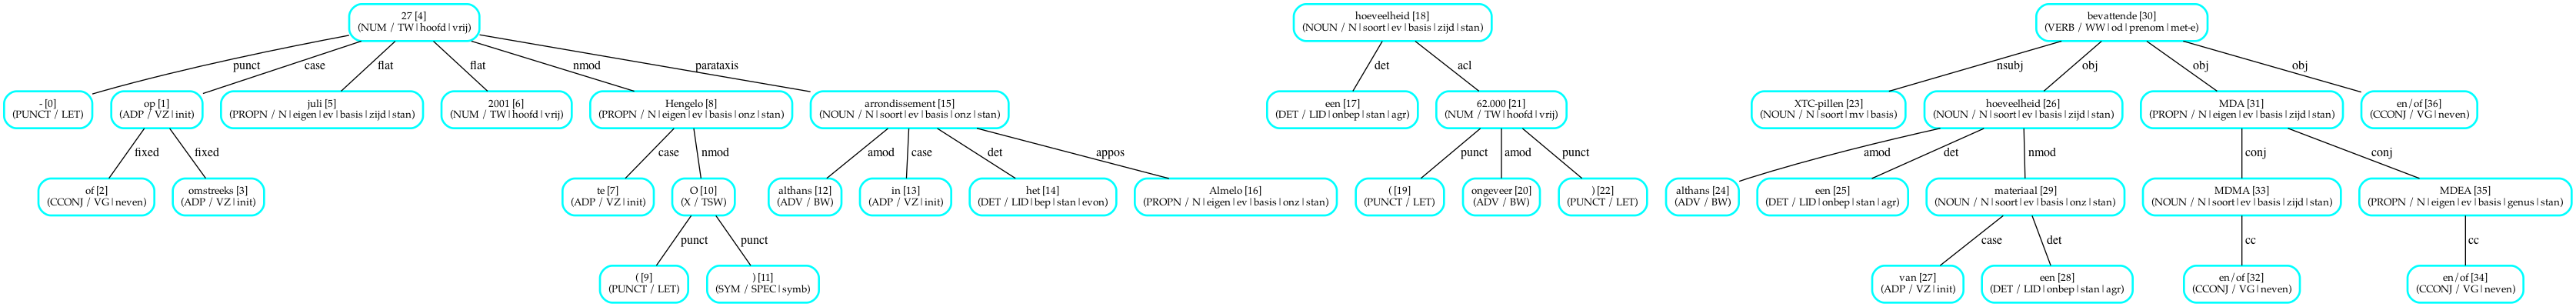

In [58]:
png = visualise_spacy_tree.create_png(nlp(extext3))
display(Image(png))

In [44]:
extract_info('De verdachte heeft omstreeks 1 januari 2000 cocaïne in 5 kilogram bananen naar Duitsland vervoerd.')

{'drug': cocaïne, naar: [Duitsland], 'volume': 5, 'volume_type': kilogram}


# Sandbox

In [1]:
import visualise_spacy_tree


In [39]:
from IPython.display import Image

In [28]:
doc = nlp(' Last year, I spoke about the Ujjwala programme , through which, I am happy to report, 50 million free liquid-gas connections have been provided so far')




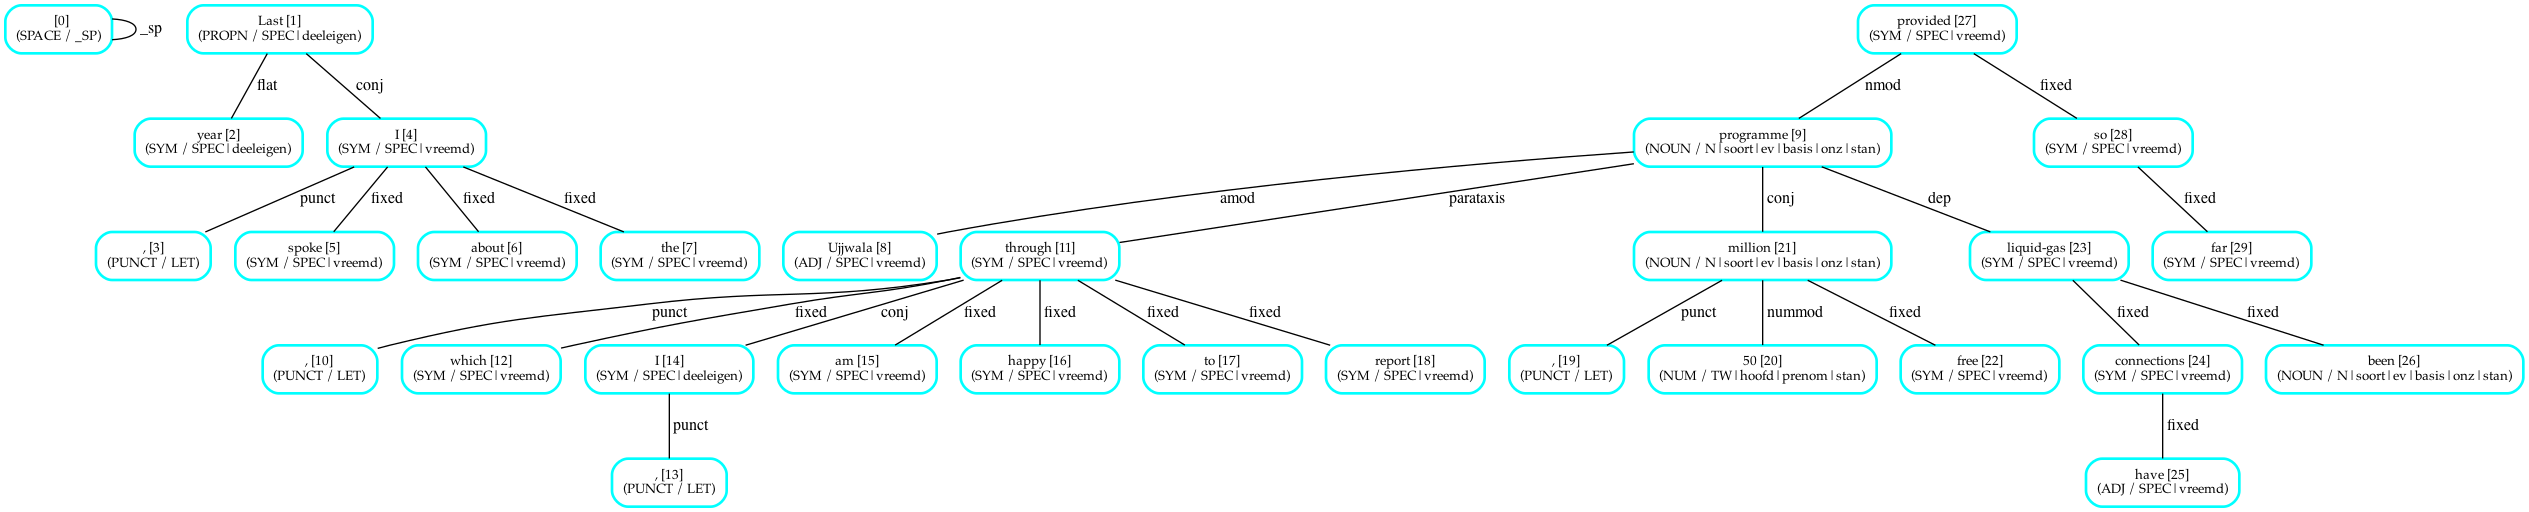

In [46]:
png = visualise_spacy_tree.create_png(doc)
display(Image(png))

## Word2Vec

### Split sentences

In [174]:
# -*- coding: utf-8 -*-
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr|mr|mevr|mvr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov|nl)"
articles = "[0-9][.][0-9]"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    text = re.sub(articles,"[artikelnummer]",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [175]:
sentence_list_by_word = []
for i in range(len(merged_df)):
    doc = merged_df.iloc[i]['case text']
    sentences = split_into_sentences(doc)
    for j in sentences:
        word_list = [x for x in j.lower().rstrip().replace('.', '').split(' ') if len(x)>0]
        sentence_list_by_word.append(word_list)
        
        
print(len(sentence_list_by_word))
# print(sentence_list[8])

3746032


In [176]:
sentence_list = []
for i in range(len(merged_df[:1000])):
    doc = merged_df.iloc[i]['case text']
    sentences = split_into_sentences(doc)
    sentence_list.append(sentences)
        
        
print(len(sentence_list))

1000


In [173]:
for i in sentence_list[:10]:
    for j in i:
        print(j, '\n')

RECHTBANK NOORD-NEDERLAND Afdeling strafrecht   Locatie Leeuwarden    parketnummer 18/048259-21     Vonnis van de meervoudige kamer voor de behandeling van strafzaken d.d. 1 oktober 2021 in de zaak van het openbaar ministerie tegen de verdachte              [verdachte]   geboren op [geboortedatum] 1971 te [geboorteplaats]  thans gedetineerd te [instelling]. 

Dit vonnis is gewezen naar aanleiding van het onderzoek ter terechtzitting van 17 september 2021. 

Verdachte is verschenen bijgestaan door mr. A.C. Huisman advocaat te Deventer. 

Het openbaar ministerie is ter terechtzitting vertegenwoordigd door mr. E.R. Jepkema. 

Tenlastelegging Aan verdachte is na nadere omschrijving van de tenlastelegging ten laste gelegd dat:   1. 

hij in of omstreeks de periode van 1 oktober 2020 tot en met 19 februari 2021 meerdere malen althans eenmaal telkens te Minnertsga gemeente Waadhoeke tezamen en in vereniging met een of meer anderen althans alleen opzettelijk heeft bereid en/of bewerkt en/of ve

[artikelnummer]. 

Op de stellingen van partijen zal worden ingegaan bij de beoordeling van het geschil. 

4 De beoordeling  Gebruik van de bestuurlijke rapportage van de politie Midden-Nederland  [artikelnummer]. 

[gedaagde] heeft aangevoerd dat De Alliantie geen beroep mag doen op het politierapport omdat dit een vertrouwelijk rapport betreft dat is gericht aan de burgemeester. 

De Alliantie meent dat zij het politierapport rechtmatig heeft verkregen als belanghebbende in de bestuursrechtelijke procedure en dat zij daar in het kader van de bewijslevering in deze civiele procedure een beroep op kan doen. 

[artikelnummer]. 

Op grond van het bepaalde in artikel 152 lid 1 van het Wetboek van Burgerlijke Rechtsvordering kan bewijs worden geleverd door alle middelen tenzij de wet anders bepaalt. 

In de wet is niet bepaald dat een rapport vanwege haar vertrouwelijkheid niet mag worden gebruikt. 

De Alliantie heeft als belanghebbende in de bestuursrechtelijke procedure van het politier

### Train word2vec model on complete dataset

In [177]:
from gensim.test.utils import common_texts

create model

In [178]:
from gensim.models import Word2Vec
dutch_word2vec_model = Word2Vec(sentences=sentence_list_by_word, vector_size=100, window=5, min_count=1, workers=4)
dutch_word2vec_model.save("word2vec_dutch_court_cases.model")

load model

In [141]:
dutch_word2vec_model = Word2Vec.load("word2vec_dutch_court_cases.model")

In [211]:
sims = dutch_word2vec_model.wv.most_similar('gram', topn=10)
print([i[0] for i in sims])
# print(sims)


['gram)', 'kilogram', 'gram;', 'kg', 'kilogram)', 'kilo', 'gram);', 'kilo)', 'gram:', 'mg/l']


### Create list of agreed upon drugs by combining lists of drugs

In [181]:
list_of_drugs = ['xtc', 'mdma', 'cocaine', 'wiet', 'speed', 'bmk', 'pmk']
agreed_drugs_list = []
for drug in list_of_drugs:
    results = dutch_word2vec_model.wv.most_similar(drug, topn=100)
    for i in results:
        agreed_drugs_list.append(i[0])

agreed_drugs_list = list(set([i for i in agreed_drugs_list if agreed_drugs_list.count(i)>2]))
print(len(agreed_drugs_list))
print(agreed_drugs_list)


76
['coke', 'lsd', 'mdma)', 'ketamine', 'speed/amfetamine', 'heroïne)', 'hash', 'amfetaminepasta', 'levamisol', 'diazepam', 'mapa', 'lidocaïne', 'azijnzuuranhydride', '(mdma', 'kristallen', 'xtc-tabletten', 'amfetaminen', 'morfine', 'pillen', 'mdma-poeder', 'amfetamineolie', 'mdma', 'harddrugs', 'weed', 'eindproduct', 'gbl', 'ecstasy', 'ghb', '34-methyleendioxymethamfetamine', 'hennep)', 'cafeïne', 'wijnsteenzuur', '2-cb', 'hashish', 'mefedron', 'mdma/mda', 'mdma-pillen', 'hennep', 'xtc-pillen', 'inositol', 'hasj', 'd-metamfetamine', '(olie)', 'n-formylamfetamine', 'crack', 'pep', 'amfetaminesulfaat', 'oxazepam', 'mdma-kristallen', 'paracetamol', 'kristallisatieafval', 'cocaïne', 'marihuana', '(xtc)', 'pillen)', 'pure', '(met)amfetamine', 'cannabis', 'amfetamine)', 'amfetamine', 'crystal', 'metamfetamine', 'methamfetamine', 'opium', 'mdma-base', 'heroïne', 'xtc/mdma', 'fenacetine', '2c-b', 'hasjiesj', 'platina', '(mdma)', 'xtc', 'olie', 'amfetaminebase', 'temazepam']


### Create list of agreed upon smuggle words by combining lists of smuggle words

In [200]:
list_of_smuggle_words = ['smokkel', 'invoer', 'uitvoer', 'import', 'export', 'handel']
agreed_smuggle_list = []
for word in list_of_smuggle_words:
    results = dutch_word2vec_model.wv.most_similar(word, topn=100)
    for i in results:
        agreed_smuggle_list.append(i[0])

agreed_smuggle_list = list(set([i for i in agreed_smuggle_list if agreed_smuggle_list.count(i)>4]))
print(len(agreed_smuggle_list))
print(agreed_smuggle_list)

23
['aanvoer', 'terugwinnen', 'bronland', 'invoer', 'synthetische', 'bronlanden', 'productie', 'kweek', 'binnensmokkelen', 'verhandeling', 'verkoop', 'gesmokkelde', 'hennepteelt', 'bewerken/verwerken', 'fabricage', 'doorvoer', 'vervaardiging', 'hasjhandel', 'cocaïnehandel', 'hennepkweek', 'hennephandel', 'bewerking', 'versnijding']


In [205]:
agreed_smuggle_list = ['smokkel', 'invoer', 'uitvoer', 'import', 'export', 'handel']


In [206]:
for i in range(len(merged_df[:15])):
    curr = merged_df.iloc[i]['case text']
    sentences = split_into_sentences(curr)
    importance = []
    for i in sentences:
        if any(drug in i for drug in agreed_drugs_list) and any(smuggle_word in i for smuggle_word in agreed_smuggle_list):
            print(i, '\n')
        
        
    


hij in of omstreeks de periode 29 januari 2003 tot en met 14 februari 2003 in de gemeente Apeldoorn en/of Nijmegen en/of Asten en/of elders in Nederland tezamen en in vereniging met een ander of anderen althans alleen als deelnemer aan het handelsverkeer en/of als persoon bedoeld in artikel 1 tweede lid onder e van de verordening de minister (van Volksgezondheid Welzijn en Sport) opzettelijk niet onverwijld in kennis heeft gesteld van een of meer voorvallen die doen vermoeden dat geregistreerde stoffen die in de handel zullen worden gebracht of die voor de invoer zijn bestemd misbruikt zullen worden of kunnen worden voor de illegale vervaardiging van verdovende middelen of psychotrope stoffen; art 2 Wet Voorkoming Misbruik Chemicalien   3. 

hij in de periode 29 januari 2003 tot en met 14 februari 2003 in de gemeente Apeldoorn als deelnemer aan het handelsverkeer of als persoon bedoeld in artikel 1 tweede lid onder e van de verordening de minister (van Volksgezondheid Welzijn en Sport)

In [191]:
merged_df.iloc[0]

id                                             ECLI-NL-RBNNE-2021-5018
verdict_date                                       2021-01-10 00:00:00
publication_date                                   2021-11-23 00:00:00
verdict_type                                                 uitspraak
jurisdiction_type                                       ['Strafrecht']
case text            \n\nRECHTBANK NOORD-NEDERLAND\nAfdeling strafr...
Name: 0, dtype: object

## Semantic Search

In [88]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import SentenceTransformer, util


In [ ]:
model = SentenceTransformer("jegorkitskerkin/bert-base-dutch-cased-snli")


In [ ]:
sentences = ["This is an example sentence", "Each sentence is converted"]
embeddings = model.encode(sentences)
print(embeddings)

In [89]:
# The sentences we'd like to compute similarity about
sentences = ['Python is an interpreted high-level general-purpose programming language.',
    'Python is dynamically-typed and garbage-collected.',
    'The quick brown fox jumps over the lazy dog.']

# Get embeddings of sentences
embeddings = model.encode(sentences)

# Compute similarities
sim = util.cos_sim(embeddings[0], embeddings[1])
print("{0:.4f}".format(sim.tolist()[0][0])) # 0.6445
sim = util.cos_sim(embeddings[0], embeddings[2])
print("{0:.4f}".format(sim.tolist()[0][0])) # 0.0365

0.7669
0.4839


In [102]:
sentence_list[1]

['RECHTBANK ZUTPHEN Meervoudige economische strafkamer Parketnummer\t\t: 06/080083-03 Datum uitspraak\t: 03 juni 2003 Tegenspraak - dip\t   VERKORT VONNIS  In de zaak tegen:   \t[verdachte] \tgeboren op [adres plaats] zonder bekend GBA-adres hier ten lande \tthans gedetineerd in de penitentiaire inrichting "[naamplaats]   Onderzoek van de zaak  Dit vonnis is gewezen naar aanleiding van het onderzoek op de terechtzitting van 20 mei 2003.',
 'De tenlastelegging  Aan bovenbedoelde gedagvaarde persoon wordt tenlastegelegd dat:  1.',
 'hij op een of meer tijdstippen in of omstreeks de periode 29 januari 2003 tot en met 12 februari 2003 in de gemeente Apeldoorn en/of Nijmegen en/of Asten en/of Someren en/of Haarlem en/of Amstelveen in elk geval in Nederland tezamen en in vereniging met een ander of anderen althans alleen om een feit bedoeld in het derde of  vierde lid van artikel 10 van de opiumwet te weten het opzettelijk bereiden bewerken verwerken verkopen afleveren verstrekken vervoeren 

In [106]:
# Corpus of documents and their embeddings
# corpus = ['Python is an interpreted high-level general-purpose programming language.',
#     'Python is dynamically-typed and garbage-collected.',
#     'The quick brown fox jumps over the lazy dog.']
corpus = sentence_list[100]
corpus_embeddings = model.encode(corpus)

# Queries and their embeddings
queries = ["Welke drugs zijn "]
queries_embeddings = model.encode(queries)

# Find the top-2 corpus documents matching each query
hits = util.semantic_search(queries_embeddings, corpus_embeddings, top_k=2)

# Print results of first query
print(f"Query: {queries[0]}")
for hit in hits[0]:
    print(corpus[hit['corpus_id']], "(Score: {:.4f})".format(hit['score']))

Query: Waarheen zijn drugs gesmokkeld?
Gelet op de hoeveelheid van de aangetroffen cocaïne is duidelijk dat deze bestemd was voor de handel. (Score: 0.7086)
De handel in verdovende middelen leidt tot vele problemen in de samenleving en gaat vaak gepaard met andere vormen van criminaliteit. (Score: 0.6295)
